In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils_fig as uf

from importlib import reload

import os
import sys
sys.path.append("../include")
import hhtools
import hhsignal
import xarray as xa

uf.set_plt()

# Part of oscillatory dynamic parameters

**Load dataset and normalize them**

In [2]:
postdata = xa.load_dataarray("../three_pop_mpi/simulation_data/postdata.nc")

target_key = ("ac2p_large", "tlag_large", "ac2p_1st", "tlag_1st", "cc1p", "tlag_cc")
target_pop = ("F", "S")
target_type = ("mean", "var")

data = []
for k1 in target_key:
    for k2 in target_type:
        for k3 in target_pop:
            val = postdata.sel(dict(key=k1, type=k2, pop=k3)).data
            data.append(val.flatten())
            
            if "cc" in k1:
                break
            
data = np.array(data)
data_norm = (data - data.mean(axis=1, keepdims=True))/data.std(axis=1, keepdims=True)

**Get UMAP embedding space**

In [3]:
fname = "./postdata/umap_coord.nc"
if os.path.exists(fname):
    print("UMAP coordinate exist, load the previous reult")
    da = xa.load_dataarray(fname)
else:
    import umap
    
    params = dict(n_neighbors=200, min_dist=0.8, n_components=2, metric="euclidean", random_state=42)
    mapper = umap.UMAP(**params)
    data_trans = mapper.fit_transform(data_norm.T)
    
    da = xa.DataArray(data=data_trans,
                      coords=[("samples", np.arange(len(data_trans))),
                              ("ax", [1,2])],
                      attrs=params)
    da.to_netcdf(fname)

UMAP coordinate exist, load the previous reult


**Show dynamic parameters**

In [4]:
def sel_params(key=None, pop=None, type=None):
    return postdata.sel(dict(key=key, pop=pop, type=type)).data.flatten()

def draw_result(params, 
                figsize=(5*uf.cm, 5*uf.cm), title=None,
                s=1, edgecolor="none", 
                vmin=None, vmax=None,
                cmap="viridis", shrink=0.5, cticks=None,
                fout=None,
                **plot_opt):
    d = sel_params(**params)
    if "tlag" in params["key"]:
        d = 1/d
    
    plt.figure(figsize=figsize, dpi=120)
    plt.scatter(da[:,0], da[:,1], s=s, edgecolor=edgecolor, cmap=cmap, c=d, vmin=vmin, vmax=vmax, rasterized=True, **plot_opt)
    plt.colorbar(shrink=shrink, ticks=cticks)
    plt.axis("off")
    if title is None:
        title = params["key"]
    plt.title(title, fontsize=12)
    if fout is not None:
        uf.save_fig(fout)
    
    plt.show()

## Frequency values

Saved figure to fig2_chi_fast


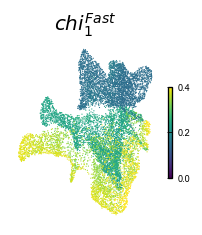

Saved figure to fig2_chi_slow


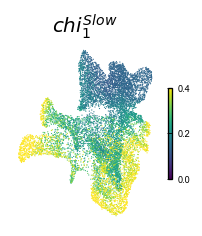

In [6]:
# Echelon
eopt = dict(vmin=0, vmax=0.4, cticks=(0, 0.2, 0.4), s=0.5)
draw_result(dict(key="chi", pop="F", type="mean"),
           title=r"$chi^{Fast}_1$", **eopt,
           fout="fig2_chi_fast")

draw_result(dict(key="chi", pop="S", type="mean"),
           title=r"$chi^{Slow}_1$", **eopt,
           fout="fig2_chi_slow")


Saved figure to fig2_f1_fast


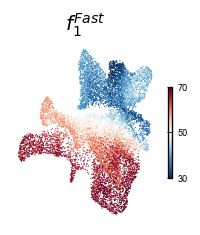

Saved figure to fig2_fm_fast


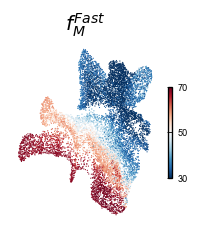

Saved figure to fig2_f1_slow


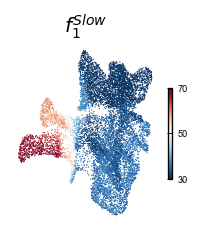

Saved figure to fig2_fm_slow


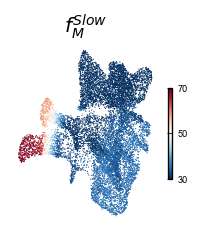

In [8]:
# Frequency
fopt = dict(vmin=30, vmax=70, cticks=(30, 50, 70), s=0.5, cmap='RdBu_r')

draw_result(dict(key="tlag_1st", pop="F", type="mean"),
           title=r"$f^{Fast}_1$", **fopt,
           fout="fig2_f1_fast")

draw_result(dict(key="tlag_large", pop="F", type="mean"),
           title=r"$f^{Fast}_M$", **fopt,
           fout="fig2_fm_fast")

draw_result(dict(key="tlag_1st", pop="S", type="mean"),
           title=r"$f^{Slow}_1$", **fopt,
           fout="fig2_f1_slow")

draw_result(dict(key="tlag_large", pop="S", type="mean"),
           title=r"$f^{Slow}_M$", **fopt,
           fout="fig2_fm_slow")

**Clustering ID**

In [9]:
cdata = xa.load_dataset("../dynamics_clustering/data/cluster_id_sub.nc")
cid = cdata.cluster_id.data.flatten()
print(np.unique(cid))

[1. 2. 3. 4. 5. 6. 7.]


# Show landmarks

In [10]:
repr_idx = uf.load_pickle("../dynamics_clustering/data/cluster_repr_points.pkl")

# size: [15, 15, 3, 16]
num_cluster = 7
nshape = (15, 15, 3, 16)

idx = []
for i in range(num_cluster):
    nid_set = repr_idx["repr_idx"][i]
    nid = nid_set[-1] + nid_set[-2]*nshape[-1] + nid_set[-3]*nshape[-1]*nshape[-2] + nid_set[0]*nshape[1]*nshape[2]*nshape[3]
    idx.append(nid)

Saved figure to fig2_cluster_map


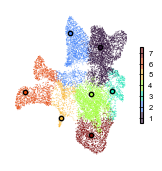

In [11]:
cmap = plt.get_cmap('turbo', len(np.unique(cid)))
# set markers
markers = ("o", "v", "*", ">", "<", "h", "s")

plt.figure(figsize=(5*uf.cm, 5*uf.cm))
plt.scatter(da[:,0], da[:,1], s=0.5, edgecolor="none", c=cid, cmap=cmap, rasterized=True, alpha=0.6)
plt.axis("off")
cbar = plt.colorbar(shrink=0.5, ticks=np.arange(1+3/7, 7-3/7+1e-3, 6/7))
cbar.set_ticklabels(["%d"%(n) for n in range(1, 8)])

for i in range(num_cluster):
    # plt.scatter(da[idx[i],0], da[idx[i],1], marker=markers[i], s=40, edgecolor='k')
    plt.scatter(da[idx[i],0], da[idx[i],1], marker="o", s=10, edgecolor='k',
               color=cmap(i/num_cluster))

uf.save_fig("fig2_cluster_map")

plt.show()

# Spectrogram & burst stats

## Set spectrogram

In [12]:
def get_psd_set(detail):
    psd_set = []
    for i in range(2):
        psd, fpsd, tpsd = hhsignal.get_stfft(detail["vlfp"][i+1], detail["ts"], 2000,
                                             frange=(5, 110))
        psd_set.append(psd)
    
    return psd_set, fpsd, tpsd


def show_psd(psd, fpsd, tpsd, vmin=0, vmax=1):
    plt.imshow(psd, aspect="auto", cmap="jet", origin="lower",
               vmin=vmin, vmax=vmax,
               extent=(tpsd[0], tpsd[-1], fpsd[0], fpsd[-1]),
               interpolation="bicubic")
    plt.ylabel("Frequency (Hz)")


def set_ticks(tl):
    plt.xlim(tl)
    plt.xticks(np.arange(tl[0], tl[1]+1e-3))
    plt.yticks(np.arange(10, 91, 20))
    plt.ylim([10, 90])
    plt.gca().set_xticklabels([])

def set_colorbar(cticks=None):
    cbar = plt.colorbar()
    cbar.set_ticks(cticks)

figsize=(3.2*uf.cm, 4*uf.cm)
summary_obj = hhtools.SummaryLoader("../gen_three_pop_samples_repr/data/")

**Landmark 7**

Saved figure to fig2_spec_lm7


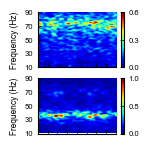

In [13]:
nt = 0 
tl = [1, 9]

detail = summary_obj.load_detail(6, nt)
psd_set, fpsd, tpsd = get_psd_set(detail)
    
plt.figure(figsize=figsize)
plt.subplot(211)
show_psd(psd_set[0], fpsd, tpsd, vmin=0, vmax=0.6)
set_ticks(tl)
set_colorbar(cticks=((0, 0.3, 0.6)))

plt.subplot(212)
show_psd(psd_set[1], fpsd, tpsd, vmin=0, vmax=1)
set_ticks(tl)
set_colorbar(cticks=((0, 0.5, 1)))

uf.save_fig("fig2_spec_lm7")
plt.show()

**Landmark 5**

Saved figure to fig2_spec_lm5


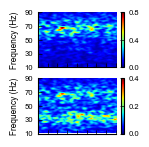

In [14]:
nt = 0 
tl = [1, 9]

detail = summary_obj.load_detail(4, nt)
psd_set, fpsd, tpsd = get_psd_set(detail)
    
plt.figure(figsize=figsize)
plt.subplot(211)
show_psd(psd_set[0], fpsd, tpsd, vmin=0, vmax=0.8)
set_ticks(tl)
set_colorbar(cticks=((0, 0.4, 0.8)))

plt.subplot(212)
show_psd(psd_set[1], fpsd, tpsd, vmin=0, vmax=0.4)
set_ticks(tl)
set_colorbar(cticks=(0, 0.2, 0.4))

uf.save_fig("fig2_spec_lm5")
plt.show()

**Landmark 4**

Saved figure to fig2_spec_lm4


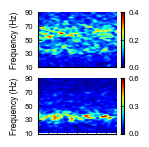

In [15]:
nt = 10
tl = [1, 9]

detail = summary_obj.load_detail(3, nt)
psd_set, fpsd, tpsd = get_psd_set(detail)
    
plt.figure(figsize=figsize)
plt.subplot(211)
show_psd(psd_set[0], fpsd, tpsd, vmin=0, vmax=0.4)
set_ticks(tl)
set_colorbar(cticks=((0, 0.2, 0.4)))

plt.subplot(212)
show_psd(psd_set[1], fpsd, tpsd, vmin=0, vmax=0.6)
set_ticks(tl)
set_colorbar(cticks=(0, 0.3, 0.6))

uf.save_fig("fig2_spec_lm4")
plt.show()

## Draw burst props
Run [source code](../gen_three_pop_samples_repr/extract_burstprobs.py) before

In [186]:
from scipy.ndimage import gaussian_filter

# def filterout_burst(bprops, mbin_t=0.01):
#     bf = np.array(bprops['burst_f'])
#     bl = np.array(bprops["burst_len"])
#     ba = np.array(bprops["burst_amp"])
    
#     idx = (bl*mbin_t >= 3/bf) & (bl*mbin_t < 8/bf)
    
#     bprops["burst_f"] = bf[idx]
#     bprops["burst_len"] = bl[idx]
#     bprops["burst_amp"] = ba[idx]
    
    
# def filterout_burst_pop(bprops_set, mbin_t=0.01):
#     for ntp in range(2):
#         filterout_burst(bprops_set["burst_props"][ntp])
        

def hist2d(y, x, yedges, xedges):
    idx = np.digitize(x, xedges, right=False)
    idy = np.digitize(y, yedges, right=False)
    
    id_nan = (idx==0) | (idx==len(xedges))
    id_nan = id_nan | (idy==0)
    id_nan = id_nan | (idy==len(yedges))

    idx = idx[~id_nan]-1
    idy = idy[~id_nan]-1
    
    matsize = (len(yedges)-1, len(xedges)-1)
    num_hist = _count(matsize, idx, idy)
    return num_hist
    

def _count(matsize, idx, idy):
    num = np.zeros(matsize)
    for n in range(len(idx)):
        num[idy[n], idx[n]] += 1
    return num        


def get_mid_pts(edges):
    return (edges[1:] + edges[:-1])/2


"""Drawing burst"""
def draw_burst_props(bprop_f, bprop_l, nbins=21, s=0.8, vmax=0.05,
                    cticks=None):
    im = hist2d(bprop_f, bprop_l, fedges, ledges)
    im = gaussian_filter(im, 0.8)
    
    plt.contourf(x, y, im/im.sum(), 
                 np.concatenate((np.linspace(0,vmax,nbins),[1])),
                 cmap="turbo", 
                 vmax=vmax, vmin=0)
    # colorbar
    if cticks is None:
        cticks = [0, vmax/2, vmax]
    cbar = plt.colorbar(ticks=cticks)
    cbar.ax.set_ylim([0, vmax])
    
    plt.ylim([10, 90])
    plt.yticks(np.arange(10, 91, 20))
    
    # set labels
    plt.xlabel("Burst duration (s)", labelpad=2)
    plt.ylabel("Frequency (Hz)")
    
mbin_t = bprop_set["attrs"]["mbin_t"]
fedges = np.arange(5, 101, 5)
ledges = np.linspace(-0.2, 0.6, 21)

y = get_mid_pts(fedges)
x = get_mid_pts(ledges)

# figsize=(2., 1.8)
figsize=(3.2*uf.cm, 4.1*uf.cm)

Saved figure to fig2_burst_prop_7


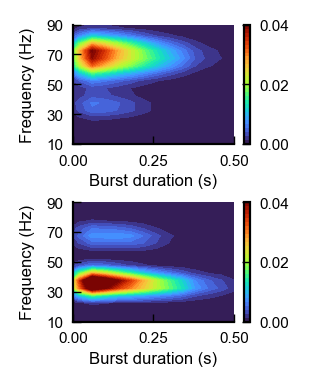

In [191]:
bprop_set = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_7.pkl")
# filterout_burst_pop(bprop_set)

xl = [0,  0.5]
plt.figure(figsize=figsize, dpi=200)
for ntp in range(2):
    plt.axes(position=(0.05, 0.6-0.55*ntp, 0.8, 0.37))
    draw_burst_props(bprop_set["burst_props"][ntp]['burst_f'], 
                     np.array(bprop_set["burst_props"][ntp]['burst_len'])*mbin_t,
                     nbins=31, vmax=0.04)
    
    plt.xlim(xl)
    plt.xticks([0, 0.25, 0.5])
    plt.xticks([0, xl[1]/2, xl[1]])

    
uf.save_fig("fig2_burst_prop_7")
plt.show()

Saved figure to fig2_burst_prop_4


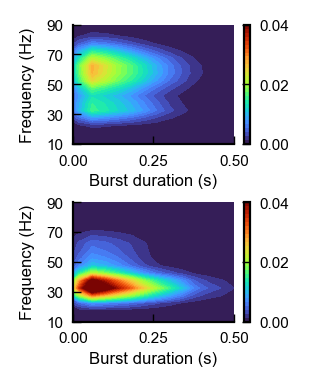

In [195]:
bprop_set = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_4.pkl")
# filterout_burst_pop(bprop_set)

xl = [0,  0.5]
plt.figure(figsize=figsize, dpi=200)
for ntp in range(2):
    plt.axes(position=(0.05, 0.6-0.55*ntp, 0.8, 0.37))
    draw_burst_props(bprop_set["burst_props"][ntp]['burst_f'], 
                     np.array(bprop_set["burst_props"][ntp]['burst_len'])*mbin_t,
                     nbins=31, vmax=0.04)
    
    plt.xlim(xl)
    plt.xticks([0, 0.25, 0.5])
    plt.xticks([0, xl[1]/2, xl[1]])

    
uf.save_fig("fig2_burst_prop_4")
plt.show()

Saved figure to fig2_burst_prop_5


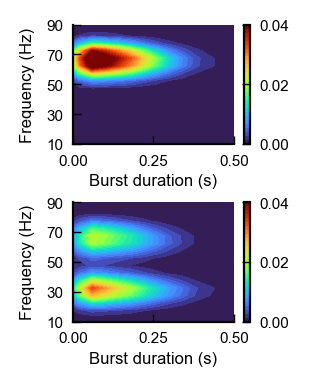

In [196]:
bprop_set = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_5.pkl")
# filterout_burst_pop(bprop_set)

xl = [0,  0.5]
plt.figure(figsize=figsize, dpi=200)
for ntp in range(2):
    plt.axes(position=(0.05, 0.6-0.55*ntp, 0.8, 0.37))
    draw_burst_props(bprop_set["burst_props"][ntp]['burst_f'], 
                     np.array(bprop_set["burst_props"][ntp]['burst_len'])*mbin_t,
                     nbins=31, vmax=0.04)
    
    plt.xlim(xl)
    plt.xticks([0, 0.25, 0.5])
    plt.xticks([0, xl[1]/2, xl[1]])

    
uf.save_fig("fig2_burst_prop_5")
plt.show()

## Compare with w.o connection cases

In [1675]:
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde

def filterout_wo_pop(bprop_set):
    for ntp in range(2):
        f = np.array(bprop_set["burst_props"][ntp]["burst_f"])
        idf = f>50 if ntp ==0 else f<40
        
        for k in ("burst_f", "burst_amp", "burst_len"):
            bprop_set["burst_props"][ntp][k] = bprop_set["burst_props"][ntp][k][idf]
            
            
def construct_df(bprop_set, bprop_wo_set):
    data = dict(pop=[], id=[], val=[], key=[])
    for k in ("burst_f", "burst_amp"):
        for ntp in range(2):
            y0 = bprop_wo_set["burst_props"][ntp][k]
            # if k == 'burst_f':
            #     y0 = y0 + np.random.randn(len(y0))
            y1 = bprop_set["burst_props"][ntp][k]

            data["val"].extend(y0)
            data["val"].extend(y1)
            data["pop"].extend([ntp]*(len(y0)+len(y1)))
            data["id"].extend([0]*len(y0)+[1]*len(y1))
            data["key"].extend([k]*(len(y0)+len(y1)))

    df = pd.DataFrame(data=data)  
    return df


# def draw_violin(df_sub):
#     sns.violinplot(df_sub, x="pop", y="val", bw=0.4, hue=df.id, gap=0.1, split=True,
#                    inner="quarter", palette=colors)


def draw_violin(df_sub, colors=None, norm_fact=0.2, bw_method=0.3):
    
    for k1 in (0, 1): # pop
        for k2 in (0, 1): # id
            data = df_sub[(df_sub["pop"]==k1) & (df_sub["id"]==k2)]["val"]
            # kde
            kde = gaussian_kde(data, bw_method=bw_method)
            xmin, xmax = data.min(), data.max()
            xadd = (xmax-xmin)/15
            x = np.linspace(xmin-xadd, xmax+xadd, 101)
            y = kde(x)
            # normalize
            dx = x[1]-x[0]
            ysum = y.sum()*dx
            ya = norm_fact/ysum
            y = y*ya
            # Draw figure
            plt.fill_betweenx(x, x1=k1+y*(-1)**(1-k2), x2=k1, alpha=0.8,
                              edgecolor="k", 
                              facecolor=colors[k2] if colors is not None else None,
                              )
            # compute quarter
            for q in (0.25, 0.5, 0.75):
                yq = np.quantile(data, q)
                xq = kde(yq)[0]*ya
                # print(xq, yq)
                plt.plot([k1, k1+xq*(-1)**(1-k2)], [yq, yq], 'k--')
    
    plt.xticks([0, 1])
    plt.xlim([-1, 2])


def set_ticks(tp=None):
    # plt.gca().get_legend().remove()
    plt.xticks([0, 1], ["Fast", "Slow"])
    plt.xlabel("Population", fontsize=12)
    if tp == "burst_f":
        plt.yticks(np.arange(10, 91, 20))
        plt.ylabel("Frequency (Hz)", fontsize=12)
        plt.title("Burst frequency", fontsize=12)
    elif tp == "burst_amp":
        plt.xlabel("Population", fontsize=12)
        plt.ylabel("Power (a.u.)", fontsize=12)
        plt.title("Burst amplitude", fontsize=12)
        

# Default setting: color palette and gap
bw = 0.4
gap = 0.1
colors = ["#BDBDBB", "#FF812F"]
figsize=(1.35, 2)

# Read wo connection bprop sets
bprop_wo2 = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_10.pkl")
filterout_burst_pop(bprop_wo2)
filterout_wo_pop(bprop_wo2)

bprop_wo1 = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_9.pkl")
filterout_burst_pop(bprop_wo1)
filterout_wo_pop(bprop_wo1)

**Landmark 7**

Saved figure to fig2_bprops_freq_7


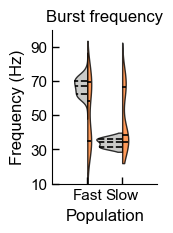

Saved figure to fig2_bprops_amp_7


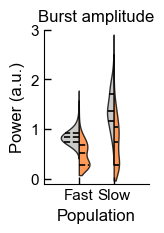

In [1676]:
bprop_set = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_7.pkl")
filterout_burst_pop(bprop_set)

df = construct_df(bprop_set, bprop_wo2)

plt.figure(figsize=figsize)
df_sub = df[df["key"]=="burst_f"]
draw_violin(df_sub, colors=colors, norm_fact=6, bw_method=0.5)
set_ticks("burst_f")
plt.ylim([10, 100])
uf.save_fig("fig2_bprops_freq_7")
plt.show()

plt.figure(figsize=figsize)
df_sub = df[df["key"]=="burst_amp"]
draw_violin(df_sub, colors=colors, norm_fact=0.2, bw_method=0.5)
set_ticks("burst_amp")
plt.ylim([-0.1, 3])
uf.save_fig("fig2_bprops_amp_7")
plt.show()

Saved figure to fig2_bprops_freq_5


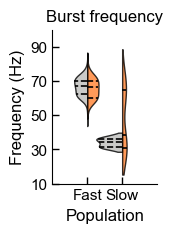

Saved figure to fig2_bprops_amp_5


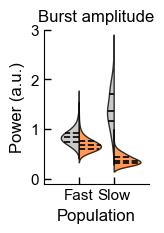

In [1677]:
bprop_set = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_5.pkl")
filterout_burst_pop(bprop_set)

df = construct_df(bprop_set, bprop_wo2)

plt.figure(figsize=figsize)
df_sub = df[df["key"]=="burst_f"]
draw_violin(df_sub, colors=colors, norm_fact=6, bw_method=0.5)
set_ticks("burst_f")
plt.ylim([10, 100])
uf.save_fig("fig2_bprops_freq_5")
plt.show()

plt.figure(figsize=figsize)
df_sub = df[df["key"]=="burst_amp"]
draw_violin(df_sub, colors=colors, norm_fact=0.2, bw_method=0.5)
set_ticks("burst_amp")
plt.ylim([-0.1, 3])
uf.save_fig("fig2_bprops_amp_5")
plt.show()

Saved figure to fig2_bprops_freq_4


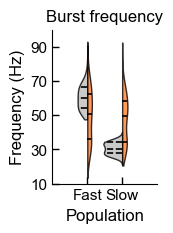

Saved figure to fig2_bprops_amp_4


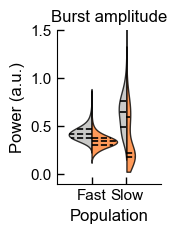

In [1678]:
bprop_set = uf.load_pickle("../gen_three_pop_samples_repr/postdata/bprops_4.pkl")
filterout_burst_pop(bprop_set)

df = construct_df(bprop_set, bprop_wo1)

plt.figure(figsize=figsize)
df_sub = df[df["key"]=="burst_f"]
draw_violin(df_sub, colors=colors, norm_fact=6, bw_method=0.5)
set_ticks("burst_f")
plt.ylim([10, 100])
uf.save_fig("fig2_bprops_freq_4")
plt.show()

plt.figure(figsize=figsize)
df_sub = df[df["key"]=="burst_amp"]
draw_violin(df_sub, colors=colors, norm_fact=0.12, bw_method=0.5)
set_ticks("burst_amp")
plt.ylim([-0.1, 1.5])
uf.save_fig("fig2_bprops_amp_4")
plt.show()

**Legend**

Saved figure to fig2_bprop_legend


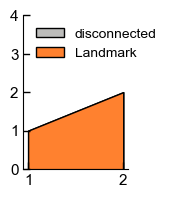

In [1679]:
plt.figure(figsize=figsize)
plt.fill_between([1,2],[1,2], color=colors[0], edgecolor="k", label="disconnected")
plt.fill_between([1,2],[1,2], color=colors[1], edgecolor="k", label="Landmark")
plt.legend(loc="upper left", edgecolor="none", fontsize=10)
plt.ylim([0, 4])
uf.save_fig("fig2_bprop_legend")
plt.show()